In [42]:
%matplotlib inline 

In [43]:
from random import randint

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from load_data import get_training_data, test_data_generator, get_validation_data, data_generator, get_test_data

In [44]:
training_data = get_training_data()
test_data = get_test_data()
validation_data = get_validation_data()

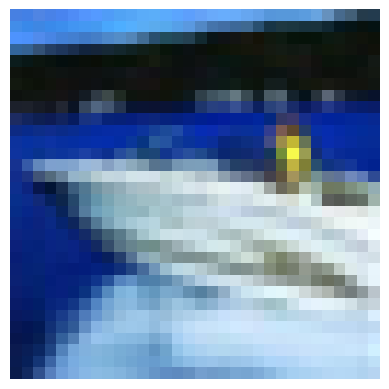

In [45]:
random_index = randint(0, len(training_data["data"]) - 1)
img = training_data["data"][random_index]

# Separate the color channels
red = img[0:1024].reshape((32, 32))
green = img[1024:2048].reshape((32, 32))
blue = img[2048:3072].reshape((32, 32))

# Stack channels along the third dimension
img_rgb = np.stack((red, green, blue), axis=2)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [46]:
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [64]:
# Define the number of classes and image size
num_classes = 10
image_size = 32
batch_size = 96

In [65]:
train_generator = data_generator(
    training_data["data"], training_data["labels"], image_size, image_size, batch_size=batch_size
)
validation_generator = data_generator(
    validation_data["data"],
    validation_data["labels"],
    image_size,
    image_size,
    batch_size=batch_size,
)

In [78]:
# Fit the model using the generator
steps_per_epoch = len(training_data["data"]) // batch_size
validation_steps = len(validation_data["data"]) // batch_size # Because of https://developers.google.com/machine-learning/glossary/#epoch
num_epochs = 25
learning_rate = 0.001

Epoch 1/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 99s 200ms/step - accuracy: 0.2164 - loss: 2.1772 - val_accuracy: 0.1053 - val_loss: 2.3432
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - accuracy: 0.3977 - loss: 1.6315 - val_accuracy: 0.4165 - val_loss: 1.6275
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 79s 191ms/step - accuracy: 0.4614 - loss: 1.4598 - val_accuracy: 0.4558 - val_loss: 1.6425
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 79s 190ms/step - accuracy: 0.5206 - loss: 1.3351 - val_accuracy: 0.5208 - val_loss: 1.4275
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step - accuracy: 0.5604 - loss: 1.2337 - val_accuracy: 0.5207 - val_loss: 1.5085
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 69s 165ms/step - accuracy: 0.5886 - loss: 1.1619 - val_accuracy: 0.5487 - val_loss: 1.3414
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 65s 156ms/step - accuracy: 0.6194 - loss: 1.0733 - val_accuracy: 0.5405 - val_loss: 1.5687
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 70s 168ms/step - accuracy: 0.6475 - loss: 1

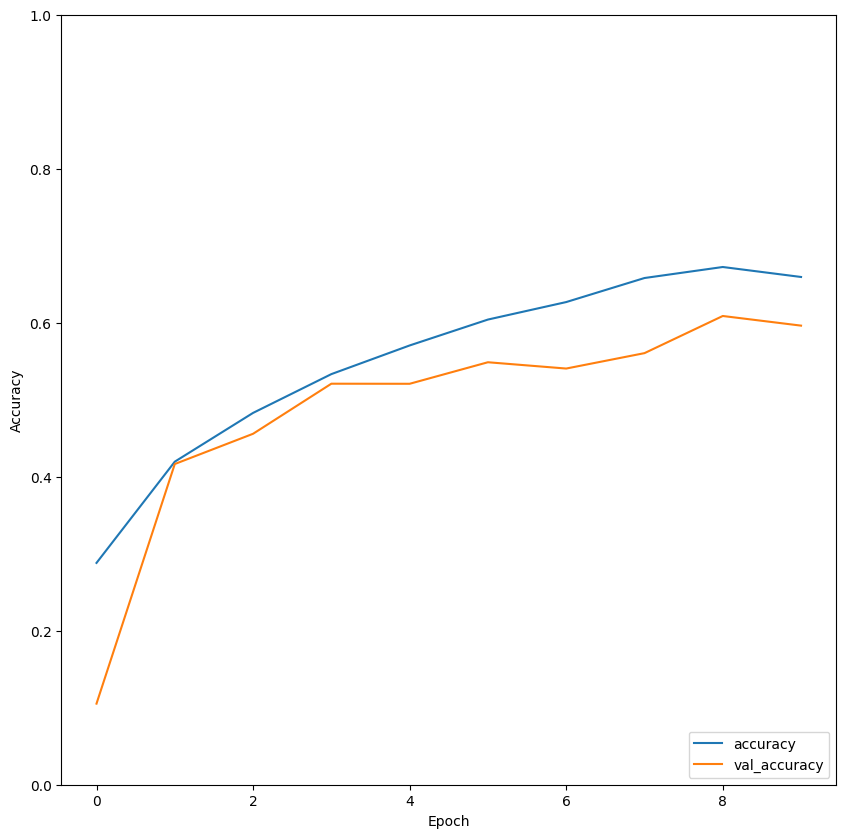

105/105 - 13s - 126ms/step - accuracy: 0.5990 - loss: 1.2473
0.5989999771118164


2024-11-08 17:50:10.871846: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2170765361025533014
2024-11-08 17:50:10.872059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14175905901256750634
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [72]:
from mobilenet import compile_mobilenet_model
mobilenet_model = compile_mobilenet_model(image_size, image_size, num_classes, learning_rate)

model = mobilenet_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=batch_size
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)

Epoch 1/10


2024-11-08 17:50:28.484646: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14008', 8 bytes spill stores, 8 bytes spill loads

2024-11-08 17:50:28.793313: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14008', 12 bytes spill stores, 12 bytes spill loads



416/416 ━━━━━━━━━━━━━━━━━━━━ 137s 245ms/step - accuracy: 0.2198 - loss: 2.1953 - val_accuracy: 0.1018 - val_loss: 2.3053
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 79s 191ms/step - accuracy: 0.4038 - loss: 1.6407 - val_accuracy: 0.0989 - val_loss: 2.3427
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 79s 190ms/step - accuracy: 0.4616 - loss: 1.4777 - val_accuracy: 0.1013 - val_loss: 2.3559
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 79s 190ms/step - accuracy: 0.5078 - loss: 1.3729 - val_accuracy: 0.1022 - val_loss: 2.3367
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 76s 184ms/step - accuracy: 0.5553 - loss: 1.2548 - val_accuracy: 0.1047 - val_loss: 2.4018
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 66s 160ms/step - accuracy: 0.5838 - loss: 1.1767 - val_accuracy: 0.0998 - val_loss: 2.3582
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 68s 164ms/step - accuracy: 0.6000 - loss: 1.1327 - val_accuracy: 0.1037 - val_loss: 2.3908
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 73s 176ms/step - accuracy: 0.6093 - loss: 1.1317 - va

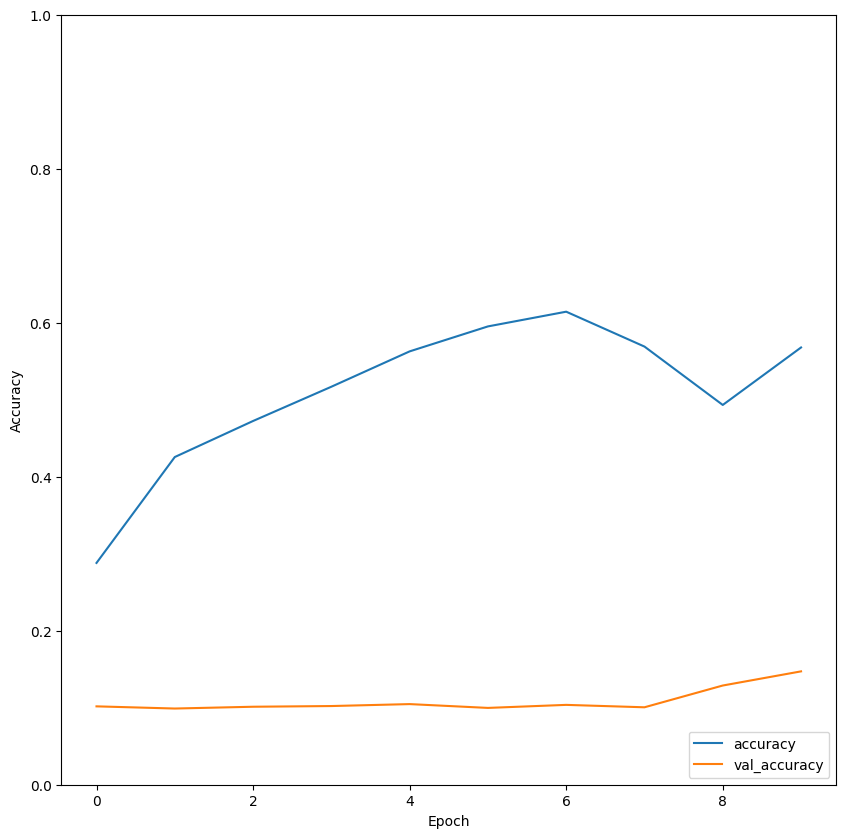

105/105 - 14s - 135ms/step - accuracy: 0.1470 - loss: 2.1302
0.1469999998807907


In [73]:
from mobilenetv2 import compile_mobilenet_v2_model

mobilenet_v2_model = compile_mobilenet_v2_model(
    image_size, image_size, num_classes, learning_rate
)

model = mobilenet_v2_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=batch_size
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)

In [74]:
from mobilenetv3 import compile_mobilenet_v3_model

mobilenet_v3_model = compile_mobilenet_v3_model(
    image_size, image_size, num_classes, learning_rate
)

model = mobilenet_v3_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=batch_size
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)

Epoch 1/10


2024-11-08 18:04:09.823562: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12477', 8 bytes spill stores, 8 bytes spill loads

2024-11-08 18:04:10.434525: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12477', 12 bytes spill stores, 12 bytes spill loads



416/416 ━━━━━━━━━━━━━━━━━━━━ 157s 278ms/step - accuracy: 0.2586 - loss: 2.0383 - val_accuracy: 0.1011 - val_loss: 2.3055
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - accuracy: 0.4339 - loss: 1.5311 - val_accuracy: 0.0958 - val_loss: 2.3112
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 78s 188ms/step - accuracy: 0.5016 - loss: 1.3783 - val_accuracy: 0.0924 - val_loss: 2.3153
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 75s 182ms/step - accuracy: 0.5482 - loss: 1.2518 - val_accuracy: 0.0956 - val_loss: 2.3309
Epoch 5/10
410/416 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5813 - loss: 1.1764

KeyboardInterrupt: 

Epoch 1/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.3164 - loss: 2.1119 - val_accuracy: 0.4732 - val_loss: 1.5018
Epoch 2/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 78s 187ms/step - accuracy: 0.5055 - loss: 1.3792 - val_accuracy: 0.5259 - val_loss: 1.3440
Epoch 3/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 77s 187ms/step - accuracy: 0.5723 - loss: 1.1950 - val_accuracy: 0.5808 - val_loss: 1.1891
Epoch 4/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 79s 190ms/step - accuracy: 0.6361 - loss: 1.0397 - val_accuracy: 0.6163 - val_loss: 1.1119
Epoch 5/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 75s 180ms/step - accuracy: 0.6823 - loss: 0.9021 - val_accuracy: 0.6196 - val_loss: 1.1242
Epoch 6/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 66s 160ms/step - accuracy: 0.7292 - loss: 0.7892 - val_accuracy: 0.6365 - val_loss: 1.0915
Epoch 7/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 70s 169ms/step - accuracy: 0.7635 - loss: 0.6877 - val_accuracy: 0.6193 - val_loss: 1.1839
Epoch 8/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 72s 173ms/step - accuracy: 0.8026 - loss: 0

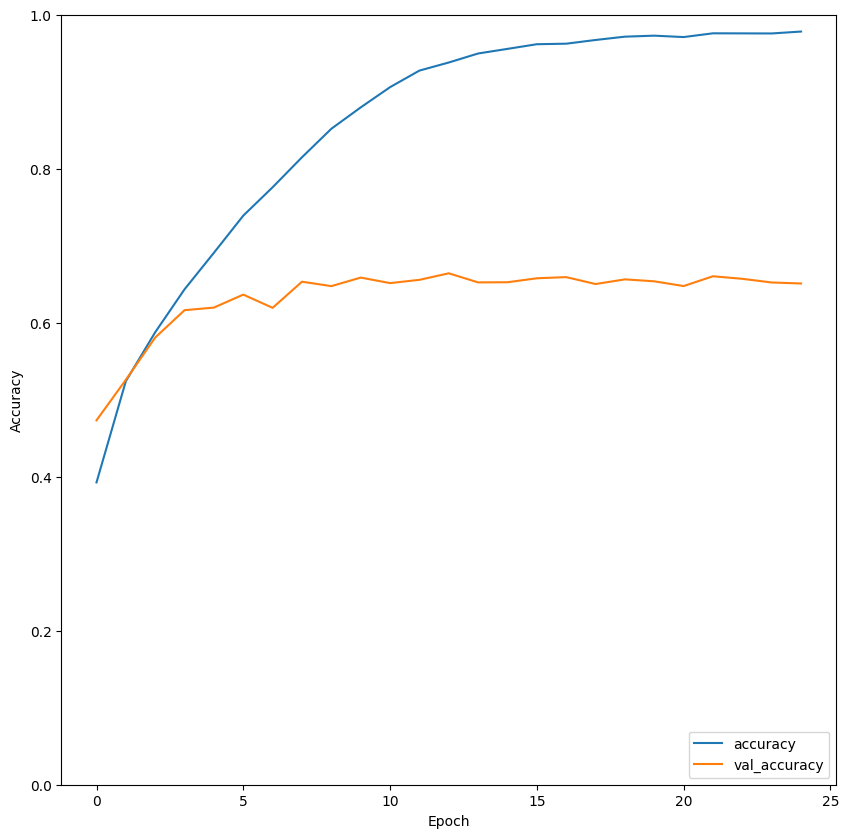

105/105 - 14s - 138ms/step - accuracy: 0.6483 - loss: 2.0201
0.6482999920845032


2024-11-08 19:08:39.035266: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2170765361025533014
2024-11-08 19:08:39.035329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14175905901256750634


In [79]:
from alexnet import compile_alexnet_model

alexnet_model = compile_alexnet_model(
    image_size, image_size, num_classes, learning_rate
)

model = alexnet_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=batch_size
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)

Epoch 1/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.2843 - loss: 4.6822 - val_accuracy: 0.3527 - val_loss: 1.9784
Epoch 2/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 74s 178ms/step - accuracy: 0.4155 - loss: 1.8339 - val_accuracy: 0.4835 - val_loss: 1.6637
Epoch 3/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 76s 183ms/step - accuracy: 0.4614 - loss: 1.7254 - val_accuracy: 0.4915 - val_loss: 1.5441
Epoch 4/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 76s 183ms/step - accuracy: 0.5161 - loss: 1.4591 - val_accuracy: 0.5263 - val_loss: 1.4962
Epoch 5/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step - accuracy: 0.5471 - loss: 1.3532 - val_accuracy: 0.5323 - val_loss: 1.4269
Epoch 6/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 65s 157ms/step - accuracy: 0.5899 - loss: 1.2037 - val_accuracy: 0.5736 - val_loss: 1.2637
Epoch 7/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 66s 158ms/step - accuracy: 0.6122 - loss: 1.1375 - val_accuracy: 0.6138 - val_loss: 1.1278
Epoch 8/25
416/416 ━━━━━━━━━━━━━━━━━━━━ 65s 156ms/step - accuracy: 0.6423 - loss: 1

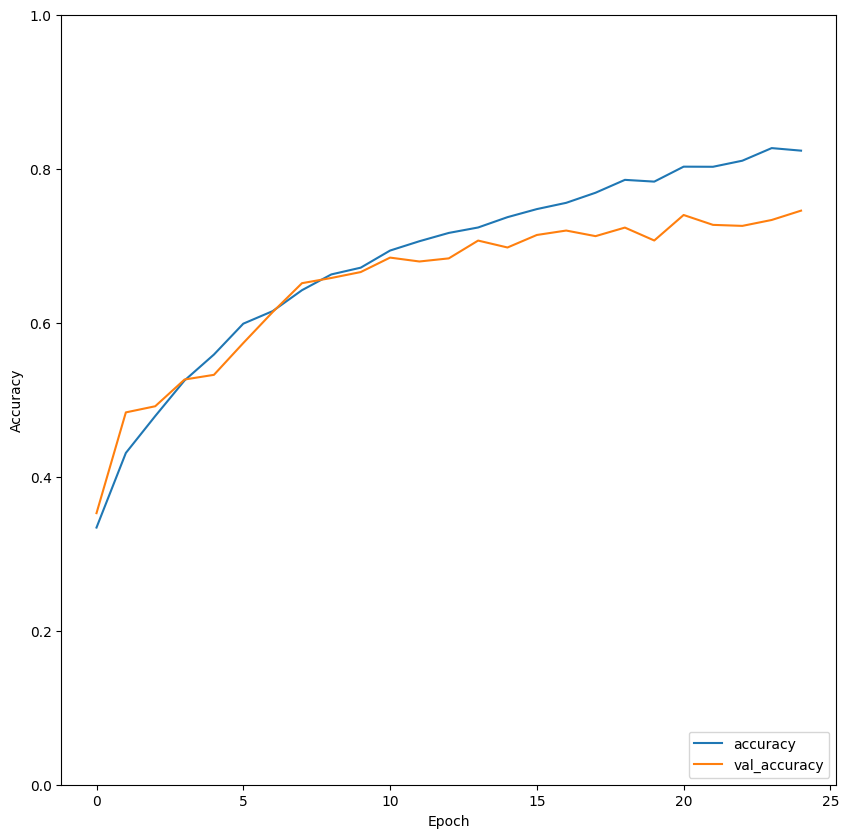

105/105 - 15s - 142ms/step - accuracy: 0.7426 - loss: 0.8567
0.7426000237464905


2024-11-08 19:37:19.148697: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2170765361025533014
2024-11-08 19:37:19.148807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14175905901256750634


In [80]:
from resnet18 import compile_resnet_model

resnet_model = compile_resnet_model(num_classes, learning_rate)

model = resnet_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=batch_size
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)